In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull
import itertools

## Review of linear programming

### Setup

Linear programming is about optimizing a linear function over positive values, subject to some linear constraints. I.e., 

$$
\begin{align*}
\text{maximise} \quad & c^Tx \\
\text{subject to} \quad & Ax\leq b \\
\text{} \quad & x\geq 0 \\
\end{align*}
$$

Key to understanding this problem is first understanding convex sets.

### Convex sets

A set $S$ is convex if for every $x_1,x_2\in S$ and $\lambda \in [0,1]$, then $\lambda x_1 + (1-\lambda)x_2\in S$

A nice property of convex sets is that the intersection of two convex sets $S_1$ and $S_2$ is also convex.

*Proof*: we need to show that for every $\lambda \in [0,1]$ then $\lambda x_1 + (1-\lambda)x_2\in S_1\cap S_2$. To be a part of the set $S_1\cap S_2$ we just need to show that the new point is in both sets. This is easily done, as $\lambda x_1 + (1-\lambda)x_2\in S_1$ (convex property of $S_1$) and $\lambda x_1 + (1-\lambda)x_2\in S_2$ (convex property of $S_2$).

### Relation to linear programming

This relates to linear programming because every half-space is in fact a convex set.

*Proof*: A half space $H$ is defined by $a^Tx\leq b$. Consider two points $x_1,x_2\in H$. Then the new point we want to check is $x=\lambda x_1 + (1-\lambda)x_2$. This can be plugged into the formula:

$$a^Tx = a^T (\lambda x_1 + (1-\lambda)x_2) = \lambda a^T x_1 + (1-\lambda)a^Tx_2$$

At most $a^T x_1$ and $a^T x_2$ are $b$, because they are both in the set, which means:

$$\lambda a^T x_1 + (1-\lambda)a^Tx_2 \leq \lambda b + (1-\lambda) b$$

And so:

$$\lambda a^T x_1 + (1-\lambda)a^Tx_2 \leq b$$

Therefore the point $x$ is in the set.

Because every constraint is a convex set, the intersection of all constraints must be a convex set too. 

### Extreme points and vertexes

An extreme point $x$ is a value in the convex set such that it cannot be written as a combination of two other points. I.e., if $x=\lambda x_1 + (1-\lambda)x_2$, then $x=x_1=x_2$. It can be shown that any point in the set can be described as a weighted combination of the extreme points in the set (see Krein-Milman theorem!!!), but for now we are interested in how they relate to vertexes.

A vertex is defined as a point in the convex set, where $n$ of the bounds are made 'tight' ($n$ refers to the number of dimensions here). If we take $n$ independent constraints and replace the $\leq$ sign with $=$, then we have $n$ hyperplanes in an $n$ dimensional space, which describes a single point. For notation we can refer to the indexes of the chosen constraints as $I$, with $A_I$ and $b_I$ as the respective values (where $A_I$ is then a $n$ by $n$ matrix). Hence we are finding $x$ where $A_I^Tx=b_I$. We still do need to check that the other constraints are satisfied as well.

A key insight into linear programming is that the extreme points and vertexes are the same.

*Proof*: We need to show that every vertex in the set is an extreme point, and then that every non-vertex point is not.

*Part 1*: Every vertex is an extreme point. Proof is by contradiction. Imagine that you had a vertex $x$, which could be defined 

$$x=\lambda y+(1-\lambda) z$$

Then it must be true that

$$A_Ix=b_I$$

And then 

$$A_Ix=\lambda A_Iy+(1-\lambda) A_Iz=b_I$$

$A_Iy$ and $A_Iz$ can be at most equal to $b$, and thus they both have to be $b$ in order to meet the condition above.

Because $A_Ix=b_I$ only has 1 solution, $x=y=z$.

*Part 2*: Every point which is not a vertex is not an extreme point.

If a point $x$ is not a vertex it can intersect with at most $n-1$ constraints. Let those other constraints we denoted as the index set $J$. We need to find a vector to move the point $x$ along (forward or backward) such that none of these constraints is violated. This means solving $A_J^T(x+d)=b_J$. Which then means solving $A_J^Td=0$. We know because this involves at most $n-1$ constraints in $n$ dimensions that there is a possible non-zero setting for the vector $d$. As a result we can define two points $y=x+\epsilon d$ and $z=x-\epsilon d$ for a small enough $\epsilon$ such that the other constraints are not violated, and $x=\frac{1}{2}y+\frac{1}{2}z$. This last step proves that $x$ is not an extreme point.

### Final insight

This is the last thing we need to get the logic behind the simplex algorithm.

This comes from the key idea that the optimal solution to the linear program must lie at an extreme point.

*Proof*: Say you have a non-extreme point $x$. This can then be written as a weighted sum of extreme points $\sum_i \lambda_i z_i$. AGAIN, see Krein-Milman theorem!!! Then the linear objective function of this point can be written as

$$c^Tx = \sum_i \lambda_i c^Tz_i$$

This function cannot exceed the highest value of $c^Tz_i$ (imagine $\lambda_i=1$), so there is at least 1 extreme point with *at least* as high a value. Therefore the global optimum must lie at one of the extreme points.

As a final note we can also show that if a vertex is not the global optima then it must be adjacent to a vertex which improves on it's function value. Why? It turns out to be a bit involved. See: https://www.cse.iitb.ac.in/~sundar/linear_optimization/lecture12a.pdf

### The simplex algorithm

The simplex algorithm basically moves between vertexes in the convex set. At each step we move to another vertex, if it improves the function. There are no local optima , so when we can't move to a better adjacent vertex then the optimal result has been found. Here is a crude version of the algorithm, which generates all neighbours, checks they don't break any other conditions, and finally picks one where the linear objective increases:

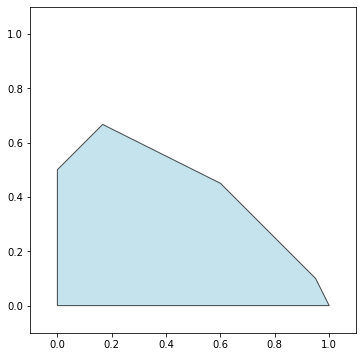

In [2]:
# lets make a test problem.
A = np.array(
    [[1,1],
     [1,2],
     [2,1],
     [-1,1],
     [-1,0], # -1 to encode the x>=0 condition as -x<=0
     [0,-1]]
)
b = np.array([1.05,1.5,2,0.5,0,0])
c = np.array([1,1])

index_combinations = list(itertools.combinations(range(len(A)), 2))
all_points = np.array([np.linalg.inv(A[np.array(comb)]).dot(b[np.array(comb)]) for comb in index_combinations])
vertices = np.array([point for point in all_points if all(A.dot(point)<=b)])

# plotting
def make_2d_polyhedron_plot(vertices):
    plt.figure(figsize=(6,6))
    hull = ConvexHull(vertices)
    plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightblue', edgecolor='black', alpha=0.7)
    min_axes = np.min(vertices)
    max_axes = np.max(vertices)
    plt.xlim(min_axes-(max_axes-min_axes)*0.1,max_axes+(max_axes-min_axes)*0.1)
    plt.ylim(min_axes-(max_axes-min_axes)*0.1,max_axes+(max_axes-min_axes)*0.1)
    plt.gca().set_aspect('equal')

make_2d_polyhedron_plot(vertices)
plt.show()

found 2 adjacent points


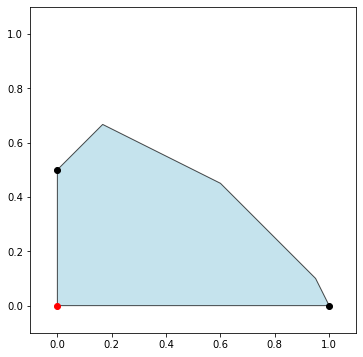

possible scores [1.  0.5]
moving to [1. 0.] with score 1.0
found 2 adjacent points


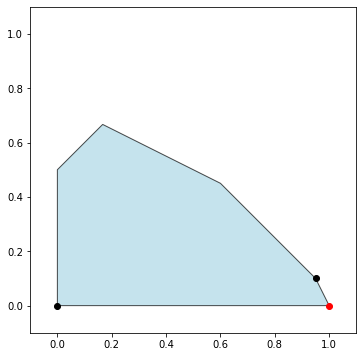

possible scores [0.   1.05]
moving to [0.95 0.1 ] with score 1.05
found 2 adjacent points


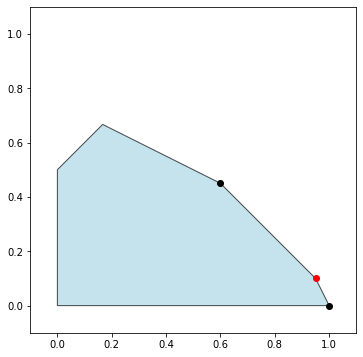

possible scores [1.05 1.  ]
no further improvement made


In [3]:
# to start the algorithm off, lets use the initial point by choosing the two last conditions (x1>0 and x2>0).
# we know this point is inside the polyhedron by definition.
current_indexes = np.array([4,5])
current_point = np.linalg.inv(A[np.array(current_indexes)]).dot(b[np.array(current_indexes)])

# now the algorithm proceeds by finding the two neighbours of that vertex and checking their values
# then if one is an improvement, we go with that
current_score = current_point.dot(c)
for i in range(10):
    adjacent_indexes = []
    adjacent_points = []
    for dimension in range(2):
        for alternative in range(len(A)):
            if not alternative in current_indexes: # can't be using this plane already
                new_indexes = current_indexes.copy()
                new_indexes[dimension]=alternative
                new_point = np.linalg.inv(A[np.array(new_indexes)]).dot(b[np.array(new_indexes)])
                if all(A.dot(new_point)<=b):
                    adjacent_indexes.append(new_indexes)
                    adjacent_points.append(new_point)
    
    print("found",len(adjacent_points),"adjacent points")
    
    adjacent_points = np.array(adjacent_points)
    make_2d_polyhedron_plot(vertices)
    plt.scatter(current_point[0],current_point[1],color="red",zorder=100)
    plt.scatter(adjacent_points[:,0],adjacent_points[:,1],color="black",zorder=100)
    plt.show()
    
    new_scores = adjacent_points.dot(c)
    
    print("possible scores", new_scores)
    
    if all(new_scores<=current_score):
        print("no further improvement made")
        break
    else:
        current_indexes = adjacent_indexes[np.argmax(new_scores)]
        current_point = adjacent_points[np.argmax(new_scores)]
        current_score = current_point.dot(c)
        print("moving to",current_point,"with score",current_score)

### Improving this algorithm

While this works, it is quite expensive. Calculating all the adjacent vertexes takes a long time as you are always needing to invert some subset of the rows in $A$. Fortunately there is a faster version of the algorithm, but in order to explain it we need to introduce some additional concepts.

### Slack variables

In most implementations of the simplex algorithm you will find them introducing the idea of slack variables. A slack variable is a *positive* variable just added on to the end of an inequality to represent the distance remaining before the constraint becomes 'tight'. These slack variables turn the inequalities it into equalities. E.g., $a+b<c$ becomes $a+b+s=c$. Note: we don't need to do this for the $a>0$ constraints, as in those cases $a$ already represents the distance.

As a result the problem can be represented as

$$
\begin{align*}
\text{maximise} \quad & w^Tx \\
\text{subject to} \quad & Ax = b \\
\text{} \quad & x\geq 0 \\
\end{align*}
$$

Where $x$ and $A$ have been modified to also include the slack variables.

If the original problem has $d$ variables, $p$ half-space constraints (ignoring the $x\geq 0$ ones), then the new $A$ has $p$ rows and $n$ columns, where $n=d+p$.

Because each variable now represents the distance before hitting a particular constraint we know that for a vertex in the original polyhedron $d$ of these variables must be set to 0.

We denote that set as the 'non-basic' variables ($N$), and the remaining set (length $p$) as the 'basic' variables ($B$). We can then write the formula $Ax=b$ as:

$$
\begin{pmatrix}
A_{N} & A_{B}
\end{pmatrix}
\begin{pmatrix}
x_{N} \\ 
x_{B}
\end{pmatrix}
=b
$$

Obviously, as all of $x_N$ is set to 0, this basically just becomes $A_Bx_B=b$. Note that here we are refering to the columns of $A$, not the rows (as before).

This gives us another way to see the problem. In the first version we are looking for $d$ half-spaces to make 'tight' in order to identify a vertex point. This meant looking for $d$ rows in the original $A$ matrix and solving equal to their corresponding $b$'s. In this new version we are looking to set $d$ values in $x$ to 0, which means looking for a subset of $p$ *columns* in the new $A$ to *keep*, along with all entries in $b$. In the old case we solved a selection of $d$ equations, in this case we solve $p$ equations.

As an example, consider I have the equations:

$$
\begin{align*}
x+y & \leq 1 \\
x & \geq 0 \\
y & \geq 0
\end{align*}
$$

In the first case we might make the first and second half-spaces both tight, in which case:

$$
\begin{align*}
x+y & = 1 \\
x & = 0
\end{align*}
$$

Which gives the trivial result $y=1$. 

With this new approach we add a slack variable, which means:

$$x + y + s = 1$$

If we set $x$ and $s$ to 0, then we just have one equation to solve:

$$0 + y + 0 = 1$$

Which gives $y=1$ too.



### Pivot calculations

We now need to calculate whether increasing a non-basic variable $x_j$ will improve the result. We know that $Ax=b$, which can then be broken down into:

$$A_Bx_B + A_jx_j = b$$

(All the other variables are 0, splitting out the new $j$'th column).

If we solve this for $x_B$ we get:

$$x_B = A_B^{-1}(b - A_jx_j)$$

The objective is then:

$$ c_Bx_B + c_jx_j = c_BA_B^{-1}(b - A_jx_j) + c_jx_j $$

Which can be rewritten as:

$$ c_BA_B^{-1}b - c_BA_B^{-1}A_jx_j + c_jx_j $$

If we take the gradient wrt. $x_j$ we get:

$$ c_j - c_BA_B^{-1}A_j $$

If this quantitity is *positive* it means that we are improving the solution. What is happening here is we are pushing the current point away from one of the 'tight' bounds it was up against. Instead of saying that the point had to lie at the edge of the half-space (which is what a non-basic variable says, when the weight is 0), we now move it a tiny bit further away (Note: there is still only 1 point which then satisfies all equations). If the objective increases as we move the point further along, then we want to continue until we hit another vertex.

We need to make sure that none of the basis variables fall below 0. From before we know:

$$x_B = A_B^{-1}(b - A_jx_j)$$

Which means for a given index $i$:

$$x_{Bi} = A_{Bi}^{-1}(b_i - A_{ji}x_j)$$

Which becomes:

$$0 = A_{Bi}^{-1}b_i - A_{Bi}^{-1}A_{ji}x_j$$

And then:

$$x_j = A_{Bi}^{-1}b_i / A_{Bi}^{-1}A_{ji}$$

Finally:

$$x_j = A_{Bi}^{-1}(b_i / A_{ji})$$

So to find the largest value of $x_j$ possible we just calculate $A_B^{-1} \frac{b}{A_j}$ and take the minimum. This means 1 variable has exited the basis (gone to 0) and another has entered the basis. 

This gives us a new way to do the simplex algorithm. Below we show this new approach, and then later we discuss the final improvement which gets rid of the need to calculate $A_B^{-1}$

B: [2 3 4 5]
x: [0.   0.   1.05 1.5  2.   0.5 ]


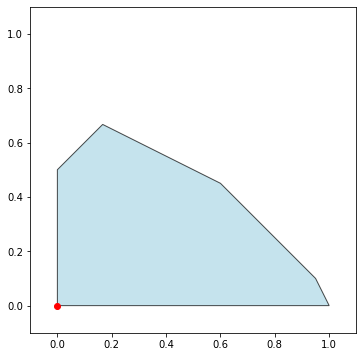

gradients: [1. 1. 0. 0. 0. 0.]
entering index: 0
ratios: [1.05 1.5  1.    inf]
exiting index: 4
B: [2 3 0 5]
x: [1.   0.   0.05 0.5  0.   1.5 ]


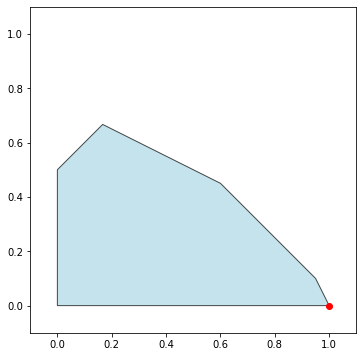

gradients: [ 0.   0.5  0.   0.  -0.5  0. ]
entering index: 1
ratios: [0.05  inf 1.   1.5 ]
exiting index: 2
B: [1 3 0 5]
x: [0.95 0.1  0.   0.35 0.   1.35]


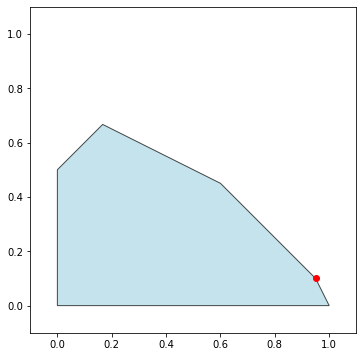

gradients: [ 0.  0. -1.  0.  0.  0.]
gradients all negative, exiting


In [4]:
# make A from above, but with the slack variables (and without the >0 conditions)
A_ = np.array(
    [[1,1,1,0,0,0],
     [1,2,0,1,0,0],
     [2,1,0,0,1,0],
     [-1,1,0,0,0,1]]
)
b_ = np.array([1.05,1.5,2,0.5])
c_ = np.array([1,1,0,0,0,0]) # values of 0 for the slack variables

B = np.array([2,3,4,5]) # these are the p columns in A we are keeping, starting the x1 and x2 set to 0.

for i in range(1000):
    A_B_inv = np.linalg.inv(A_[:,B])
    x_ = np.zeros(6)
    x_[B] = A_B_inv.dot(b_)
    print("B:",B)
    print("x:",x_)
    make_2d_polyhedron_plot(vertices)
    plt.scatter(x_[0],x_[1],color="red",zorder=100)
    plt.show()
    gradients = c_ - c_[B].dot(A_B_inv).dot(A_)
    print("gradients:", gradients)
    if(max(gradients)<=0):
        print("gradients all negative, exiting")
        break
    else:
        entering_index = np.argmax(gradients)
        print("entering index:",entering_index)
        ratios = A_B_inv.dot(b_ / A_[:,entering_index])
        ratios[ratios<0] = np.inf
        print("ratios:",ratios)
        exiting_index = B[np.argmin(ratios)]
        print("exiting index:",exiting_index)
        B[B==exiting_index]=entering_index

This can then be improved in two further ways, described in: https://resources.mpi-inf.mpg.de/departments/d1/teaching/ss11/OPT/lec6.pdf

Firstly, we can make the computation of $A_B^{-1}$ cheaper, by using useful formulas for updating the inverse of a matrix when only 1 column changes (also see Sherman-Morrison formula).

### Calculating the inverse changes faster

In order to calculate the inverse of the matrix we use gauss-jordan elimination. Say we have the matrix $A$:

$$
\begin{bmatrix}
3 & 1 & 0 \\
1 & -1 & 0 \\
0 & 1 & 1
\end{bmatrix}
$$

We create a new matrix defined as $\begin{bmatrix}A & I\end{bmatrix}$, where $I$ is the identity:

$$
\begin{bmatrix}
3 & 1 & 0 & 1 & 0 & 0 \\
1 & -1 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 1
\end{bmatrix}
$$

By applying elementary row operations we can transform this matrix. To have the identity on the left. I.e.,

$
\begin{bmatrix}
3 & 1 & 0 & 1 & 0 & 0 \\
1 & -1 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 1
\end{bmatrix}
$

*Dividing the top row by 3*

$
\begin{bmatrix}
1 & \frac{1}{3} & 0 & \frac{1}{3} & 0 & 0 \\
1 & -1 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 1
\end{bmatrix}
$

*Subtracting top row out from the other rows*

$
\begin{bmatrix}
1 & \frac{1}{3} & 0 & \frac{1}{3} & 0 & 0 \\
0 & -\frac{4}{3} & 0 & -\frac{1}{3} & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 1
\end{bmatrix}
$

*Dividing the second row by $-\frac{4}{3}$*

$
\begin{bmatrix}
1 & \frac{1}{3} & 0 & \frac{1}{3} & 0 & 0 \\
0 & 1 & 0 & \frac{1}{4} & -\frac{3}{4} & 0 \\
0 & 1 & 1 & 0 & 0 & 1
\end{bmatrix}
$

*Subtracting middle row out from the other rows*

$
\begin{bmatrix}
1 & 0 & 0 & \frac{1}{4} & \frac{1}{4} & 0 \\
0 & 1 & 0 & \frac{1}{4} & -\frac{3}{4} & 0 \\
0 & 0 & 1 & -\frac{1}{4} & \frac{3}{4} & 1
\end{bmatrix}
$

This now gives us the matrix $\begin{bmatrix}I & A^{-1}\end{bmatrix}$

Why? Because when we do row operations we are essentially pre-multiplying our original formula by some matrix $Q$. So we have:

$$Q\begin{bmatrix}A & I\end{bmatrix} = \begin{bmatrix}I & K\end{bmatrix}$$

Which means $K=QI=Q$, and because $QA=I$ then $Q$ is the inverse $A^{-1}$.

With the simplex method we are replacing 1 column in $A$. E.g., say we replace the second column in $A$ with 

$$
\begin{bmatrix}
4 \\
2 \\
1
\end{bmatrix}
$$

If we then apply all the same transformations as before, then all that will happen is the second column will change as well (because we are just applying row operations). The new values in the second column can then be found easily by re-running the row operations from before (i.e., pre-multiplying by $Q$):

$$
\begin{bmatrix}
\frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{4} & -\frac{3}{4} & 0 \\
-\frac{1}{4} & \frac{3}{4} & 1
\end{bmatrix}
\begin{bmatrix}
4 \\
2 \\
1
\end{bmatrix}
=
\begin{bmatrix}
\frac{3}{2} \\
-\frac{1}{2} \\
\frac{3}{2}
\end{bmatrix}
$$

So we end up with a matrix where most of the work has already been done:

$
\begin{bmatrix}
1 & \frac{3}{2} & 0 & \frac{1}{4} & \frac{1}{4} & 0 \\
0 & -\frac{1}{2} & 0 & \frac{1}{4} & -\frac{3}{4} & 0 \\
0 & \frac{3}{2} & 1 & -\frac{1}{4} & \frac{3}{4} & 1
\end{bmatrix}
$

All we then need to do is apply a few row operations again to get the identity:

*Dividing the middle row by $-\frac{1}{2}$*

$
\begin{bmatrix}
1 & \frac{3}{2} & 0 & \frac{1}{4} & \frac{1}{4} & 0 \\
0 & 1 & 0 & -\frac{1}{2} & \frac{3}{2} & 0 \\
0 & \frac{3}{2} & 1 & -\frac{1}{4} & \frac{3}{4} & 1
\end{bmatrix}
$

*Subtracting middle row out from the other rows*

$
\begin{bmatrix}
1 & 0 & 0 & 1 & -2 & 0 \\
0 & 1 & 0 & -\frac{1}{2} & \frac{3}{2} & 0 \\
0 & 0 & 1 & \frac{1}{2} & -\frac{3}{2} & 1
\end{bmatrix}
$

This enables us to update the inverse fairly quickly. I haven't written the code for this, as it would be essentially the same as the above.

In [5]:
print(np.linalg.inv(np.array([[3,4,0],[1,2,0],[0,1,1]])))

[[ 1.  -2.   0. ]
 [-0.5  1.5  0. ]
 [ 0.5 -1.5  1. ]]


### Finally, the tableau method

Now that we have gone through everything above it's possible to introduce the tableau method for running the simplex algorithm. With the tableau method all we do is store $A_B^{-1}A$ and $A_B^{-1}b$ instead of the inverse itself. Each column in the tableau represents a variable (including the slack ones). The values are $A_B^{-1}A$. We also have an additional column on the right for $A_B^{-1}b$, a column on the left for $B$, and the gradients are also stored in an additional row at the bottom. Taking the problem from before the tableau would start out as:

$
\begin{array}{c|cccccc|c}
\text{basis} & x_1 & x_2 & s_1 & s_2 & s_3 & s_4 & \text{solution} \\
\hline
s_1 & 1 & 1 & 1 & 0 & 0 & 0 & 1.05 \\
s_2 & 1 & 2 & 0 & 1 & 0 & 0 & 1.5 \\
s_3 & 2 & 1 & 0 & 0 & 1 & 0 & 2 \\
s_4 & -1 & 1 & 0 & 0 & 0 & 1 & 0.5 \\
\hline
Z & -1 & -1 & 0 & 0 & 0 & 0 & 0 \\
\end{array}
$

The tableau starts this way because when we select all the slack variables to form our basis the matrix $A_B^{-1}$ is just the identity. Therefore the values on the right are just $b$ and the values in the middle are just $A$. The values at the bottom are the negative gradients, which it's easy to see are also just $-c$. The bottom right cell contains the current objective function.

Using this table it is easy to calculate what our entering and exiting variables should be. To get our entering variable we need to find one where the gradient is positive (or the negative gradient is negative). Here this could be $x_1$. Then we need to find our exiting variable, which requires finding the minimum of the positive values of the ratios $A_B^{-1}(b / A_j)$. This is then just $A_B^{-1}b / A_B^{-1}A_j$, so we just divide the values in our solution column by the values in the main bit of the tableau. Using $x_1$ as our entering variable we get:

$
\begin{array}{c|cccccc|c|c}
\text{basis} & x_1 & x_2 & s_1 & s_2 & s_3 & s_4 & \text{solution} & \text{ratio} \\
\hline
s_1 & 1 & 1 & 1 & 0 & 0 & 0 & 1.05 & 1.05 \\
s_2 & 1 & 2 & 0 & 1 & 0 & 0 & 1.5 & 1.5 \\
s_3 & 2 & 1 & 0 & 0 & 1 & 0 & 2 & 1 \\
s_4 & -1 & 1 & 0 & 0 & 0 & 1 & 0.5 & -0.5 \\
\hline
Z & -1 & -1 & 0 & 0 & 0 & 0 & 0 \\
\end{array}
$

From this we can see the exiting variable will be $s_3$. So $s_3$ will be set to 0, and $x_1$ will be free. Now the magic is how we update $A_B^{-1}A$ and $A_B^{-1}b$.

This is a bit tricky, but goes like this. What we are going to do is apply elementary row operations to set our entering variable column to 1 in the exiting variable row, and 0 elsewhere. In the case where we are removing $s_3$ and adding $x_1$ this means moving to:

$
\begin{array}{c|cccccc|c}
\text{basis} & x_1 & x_2 & s_1 & s_2 & s_3 & s_4 & \text{solution} \\
\hline
s_1 & 0 & -\frac{1}{2} & 1 & 0 & -\frac{1}{2} & 0 & 0.05 \\
s_2 & 0 & \frac{3}{2} & 0 & 1 & -\frac{1}{2} & 0 & 0.5 \\
x_1 & 1 & \frac{1}{2} & 0 & 0 & \frac{1}{2} & 0 & 1 \\
s_4 & 0 & \frac{3}{2} & 0 & 0 & \frac{1}{2} & 1 & 1.5 \\
\hline
Z & 0 & -\frac{1}{2} & 0 & 0 & \frac{1}{2} & 0 & 1 \\
\end{array}
$

Now we can note that this new transformation was just like pre-multiplying by some $Q$ on the original table, so $QA_B^{-1}A$ and $QA_B^{-1}b$. Now if we look at the new basis variables ($B_{new}$) we can see that they form the identity matrix (as none of the remaining basis variable columns were affected, and the transform was designed to fix the entering variable column). As a result we can say $QA_B^{-1}A_{B_{new}}=I$. This can then be refactored to show $QA_B^{-1}=A_{B_{new}}^{-1}$. I.e., the transformations we have applied have been exactly the transforms we would have applied to the inverse matrix, if we were doing it that way. It then follows that the solutions to the variables we do store have been updated correctly too. 

The final final thing to get is why the last row (the gradients / objective) is also updated in the same manner. The gradients in the final row are given by the formula $c - c_B^TA_B^{-1}A$. When we get the value in the entering variable column to 0 what we are doing is adding a new row from $A_B^{-1}A$ multiplied by a constant $\lambda$. We can write this row as $dA$, where $d$ is the row in $A_B^{-1}$. This means our new values will be $c - (c_B^TA_B^{-1}-\lambda d)A$. We need to show then that $c_B^TA_B^{-1}-\lambda d$ is equal to $c_{B_{new}}^TA_{B_{new}}^{-1}$. If we can show that, then the formula is the same. 

The cost of all new basis variables under this scheme will always be 0. Thus we have $c_{B_{new}} - (c_B^TA_B^{-1}-\lambda d)A_{B_{new}}=0$. This can be re-written as $(c_B^TA_B^{-1}-\lambda d)A_{B_{new}}=c_{B_{new}}$, and then finally as $(c_B^TA_B^{-1}-\lambda d)=c_{B_{new}}A_{B_{new}}^{-1}$.

Finally finally finally, we should show that these row operations / pivots also maintain the objective function value in the bottom corner. This is done in exactly the same manner as the above. See https://resources.mpi-inf.mpg.de/departments/d1/teaching/ss11/OPT/lec6.pdf for more details.

### Extension of the approach

At first glance linear programming might seem limited, particularly as we can't have negative variables. However, it turns out that a lot of problems can be reformulated into the above structure by converting weights or adding variables. E.g., 
* If we have a value $x$ which can be negative, we can then replace it with two positive variables $q$ and $u$, where $x = q - u$. For every instance of $x$ in a formula we just replace it with $q - u$. 
* To deal with $\geq$ conditions we can just flip the corresponding weights.
* For equalities we can just use a $\geq$ and $\leq$ condition at the same time.